# Miscellaneous Introductory Data Lab Examples

Based on notebooks by Robert Nikutta and Stephanie Juneau, Data Lab Team, NOAO

Edited by Zeljko Ivezic, University of Washington

This notebook is similar to ZI_BasicExamples2, but here we query and analyze data for stars (PSF) only.



In [1]:
# first, let's login to Data Lab server: 
from dl import authClient as ac, queryClient as qc, storeClient as sc
from getpass import getpass
token = ac.login(raw_input("username: "),getpass("password: "))
print(token.split('.')[0])

ImportError: No module named dl

In [2]:
ac.isUserLoggedIn('ivezic')

u'True'

In [3]:
# Import packages including some Data Lab (dl) specific ones.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from astropy.utils.data import download_file  #import file from URL
from scipy.stats import binned_statistic_2d
from astropy.table import Table
from dl import authClient as ac, queryClient as qc
%matplotlib inline
# from cStringIO import StringIO  # C script to handle string format, Python 2
from io import StringIO   # Python 3 version
print('Done importing')

Done importing


### NSC Examples

We will focus on accessing data from the NOAO Source Catalog (NSC) and some basic data exploration: 

1) learn about the table structure  

2) run a query

3) make a few simple plots

4) import external code (e.g. from astroML) and execute complex analysis

In [4]:
# what tables do we have in NSC Data Release 1?  
print(qc.schema('nsc_dr1',format='json',profile='default'))


Schema: nsc_dr1

      Table Name   Description
      ----------   -----------
            chip   CCD information table
        coverage   Survey coverage table
        exposure   Exposures contributing to the catalog
     nsc_allwise   NSC vs ALLWISE 1-arcsec crossmatch
         nsc_des   NSC vs DES 1-arcsec crossmatch
       nsc_lsdr4   NSC vs DECaLS DR4 1-arcsec crossmatch
       nsc_lsdr5   NSC vs DECaLS DR5 1-arcsec crossmatch
          object   Primary object table



In [5]:
print(qc.schema('nsc_dr1.object',format='json',profile='default'))


Schema: nsc_dr1
 Table: object

     Column Name   Description
     -----------   -----------
              ra   Right ascension (J2000.0) of object, in degrees
             dec   Declination (J2000.0) of object, in degrees
            glon   Galactic Longitude
            glat   Galactic Latitude
            elon   Ecliptic Longitude
            elat   Ecliptic Latitude
           raerr   Uncertainty of RA
          decerr   Uncertainty in DEC
            pmra   Proper motion in RA*cos(DEC)
           pmdec   Proper motion in DEC
         pmraerr   Uncertainty in PMRA
        pmdecerr   Uncertainty in PMDEC
             mjd   Mean Modified Julian Date
        deltamjd   Range of Modified Julian Date
            umag   Weighted-average u-band magnitude
            urms   RMS scatter in u from multiple measurements of this object
            uerr   Uncertainty in mean u-band magnitude
          uasemi   u-band profile RMS along major axis, in arcseconds
          ubsemi   u-band profil

#### Query

Execute a simple query to get basic astrometry and photometry for
NSC sources from the SDSS Stripe 82 region.

SDSS Stripe 82 region: about 2.5 deg wide equatorial strip from RA=20h to RA=4h.

For the entire Stripe 82 region, the query below should have 
"dec > -1.3 and dec < 1.3" instead of "dec > -0.3 and dec < 0.3"

However, it seems unstable when running the entire

In [6]:
# Write query statement (adql) to retrieve data from ls_dr5.tractor_primary table
query = """
        SELECT ra, dec, pmra, pmraerr, pmdec, pmdecerr, mjd, deltamjd, 
               gmag, grms, gerr, rmag, rrms, rerr, imag, irms, ierr,
               class_star, fwhm, ebv, nphot 
        FROM nsc_dr1.object 
        WHERE (((ra > 315 or ra<45)) and dec > -0.3 and dec < 0.3 and
                rmag > 13 and rmag < 23.0 and rerr < 0.3)
        LIMIT 8000000"""
response = qc.query(token, adql=query, fmt='csv')
# Reformat output into a table
result = Table.read(StringIO(response), format='csv')  # dictionary
# Print a few rows from the result table
print(result[:5])
len(result)

      ra            dec            pmra      ...    fwhm       ebv     nphot
------------- --------------- -------------- ... --------- ----------- -----
315.007119417 -0.297991540155 -14.2115736417 ...  1.613497 0.077035002    14
315.013418057 -0.297743518894  52.6160551293 ... 2.5917599 0.076640002    12
315.004919152 -0.294219503025  45.6715668327 ...  1.355329    0.077537    14
315.002199511 -0.290939056645  53.0641718432 ...  1.506146 0.078013003    12
315.002411885 -0.287152821704 -7.91445937276 ...  2.633656 0.078388996    14


/data0/sw/anaconda2/lib/python2.7/site-packages/astropy/utils/data.py:225: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if signature[:3] == b'\x1f\x8b\x08':  # gzip
/data0/sw/anaconda2/lib/python2.7/site-packages/astropy/utils/data.py:265: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif signature[:3] == b'\xfd7z':  # xz


1793566

In [7]:
ra = result['ra']
dec = result['dec'] 
rmag = result['rmag'] 
rmagerr = result['rerr'] 
rmagrms = result['rrms'] 
rr = rmagrms/rmagerr 
pmra = result['pmra'] 
pmdec = result['pmdec'] 
pmraerr = result['pmraerr'] 
pmdecerr = result['pmdecerr'] 
SG = result['class_star']
nphot = result['nphot']
deltamjd = result['deltamjd']

In [8]:
ra = result['ra']
dec = result['dec'] 
raW = np.where(ra>180, ra-360, ra)
snr = 1.0/rmagerr
SNRcutBright = 20.0
SNRcutFaint = 10.0
raS = ra[(snr<SNRcutBright)&(snr>SNRcutFaint)]
raWS = raW[(snr<SNRcutBright)&(snr>SNRcutFaint)]
decS = dec[(snr<SNRcutBright)&(snr>SNRcutFaint)]
np.size(raS)

418726

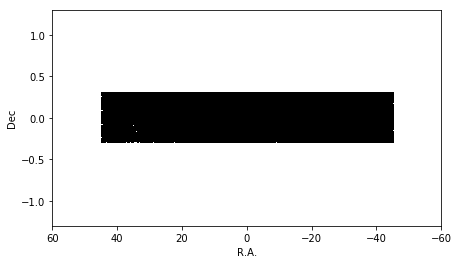

In [9]:
# plot data
fig = plt.figure(figsize=(12, 12))
ax = fig.add_axes([0.5, 0.7, 0.45, 0.25])
ax.plot(raWS, decS, color='k', linestyle='none', marker=',')
ax.set_xlim(60, -60.0)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel('R.A.')
ax.set_ylabel('Dec')
plt.show()

1793566


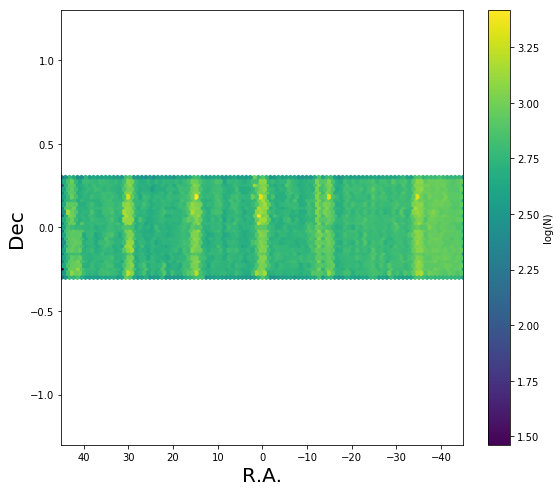

In [10]:
col0 = raW
col1 = dec 
print col0.size
# 2D-histogram of objects in the r-z vs g-r color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-45, 45.0, -1.3, 1.3))
ax1.axis([45, -45, -1.3, 1.3])
ax1.set_xlabel('R.A.',fontsize=20)
ax1.set_ylabel('Dec',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

1793566


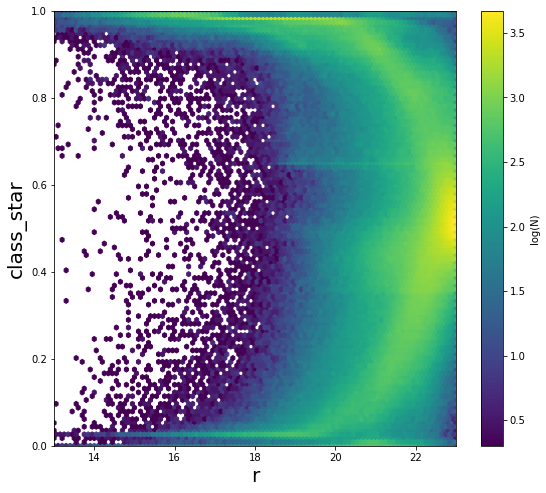

In [11]:
col0 = rmag
col1 = SG 
print col0.size
# 2D-histogram of objects in the r-z vs g-r color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(13, 23.0, 0, 1))
ax1.axis([13, 23, 0, 1])
ax1.set_xlabel('r',fontsize=20)
ax1.set_ylabel('class_star',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

1793566


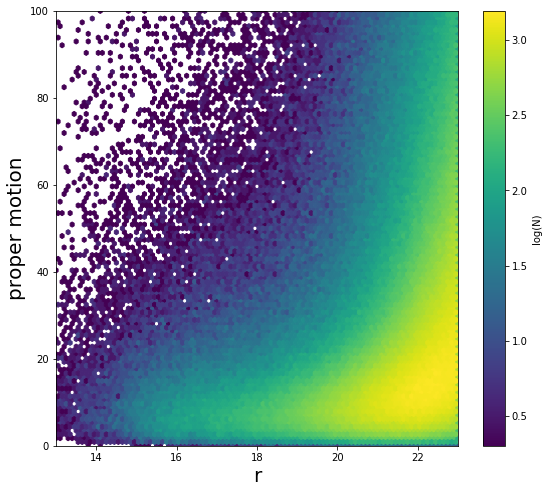

In [12]:
col0 = rmag
col1 = np.sqrt(pmra**2+pmdec**2)
print col0.size
# 2D-histogram of objects in the r-z vs g-r color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(13, 23.0, 0, 100))
ax1.axis([13, 23, 0, 100])
ax1.set_xlabel('r',fontsize=20)
ax1.set_ylabel('proper motion',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

1793566


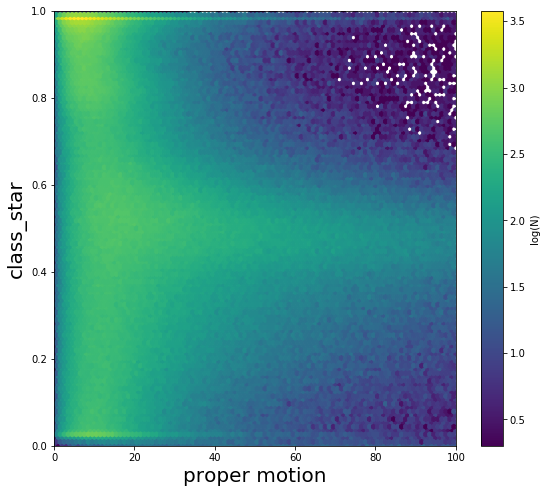

In [13]:
col0 = np.sqrt(pmra**2+pmdec**2)
col1 = SG 
print col0.size
# 2D-histogram of objects in the r-z vs g-r color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(0, 100.0, 0, 1))
ax1.axis([0, 100, 0, 1])
ax1.set_xlabel('proper motion',fontsize=20)
ax1.set_ylabel('class_star',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

In [14]:
# Select range of interest
keep = (SG > 0.5) 

# select astrometry and photometry
ra = result['ra'][keep] 
raW = raW[keep]
dec = result['dec'][keep] 
gmag = result['gmag'][keep] 
rmag = result['rmag'][keep] 
imag = result['imag'][keep] 
g_r = gmag-rmag
r_i = rmag-imag
print len(g_r)


930503


930503


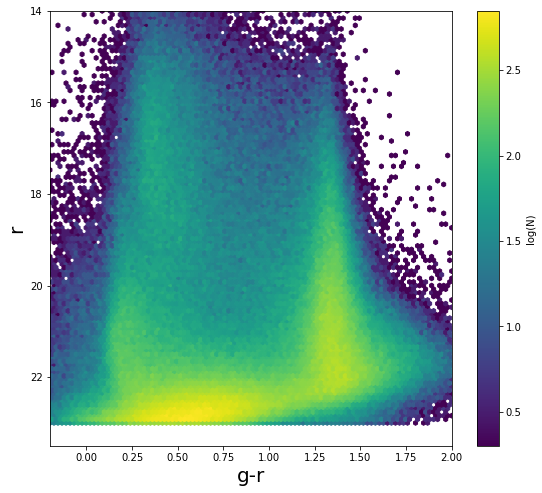

In [15]:
col0 = g_r 
col1 = rmag 
print col0.size
# 2D-histogram of objects in the r-z vs g-r color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.2, 2.0, 14, 23))
ax1.axis([-0.2, 2.0, 23.5, 14])
ax1.set_xlabel('g-r',fontsize=20)
ax1.set_ylabel('r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

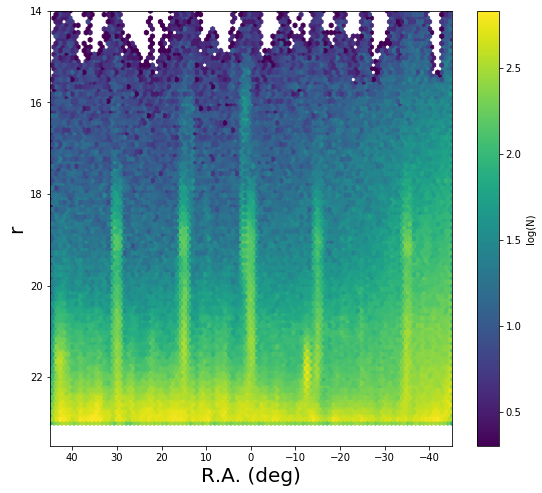

In [16]:
col0 = raW 
col1 = rmag 

# 2D-histogram of objects in the r-z vs g-r color diagram 
fig, ax1 = plt.subplots(1, 1, figsize=(9, 8))
im1 = ax1.hexbin(col0, col1, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-45, 45, 14, 23))
ax1.axis([45.0, -45.0, 23.5, 14])
ax1.set_xlabel('R.A. (deg)',fontsize=20)
ax1.set_ylabel('r',fontsize=20)

#color bar
cb = plt.colorbar(im1,label='log(N)')

## Convert to pandas dataframe and save as csv file (to be downloaded).

In [17]:
from dl.helpers import convert

In [18]:
df = convert(response,'pandas')

/data0/sw/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Returning Pandas dataframe


In [19]:
# df.to_csv('NSC_stripe82_DecPositive.csv',index=False)     # 3,692,781
# df.to_csv('NSC_stripe82_DecNegative.csv',index=False)     # 3,716,545
df.to_csv('NSC_stripe82_DecNarrow.csv',index=False)         # 1,793,566